In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d BengaliAI/numta
!unzip -qq '/content/numta.zip'

100% 1.91G/1.91G [00:19<00:00, 194MB/s]
100% 1.91G/1.91G [00:19<00:00, 107MB/s]


# Handwritting Digit Recognization

In [ ]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.layers import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Process the data

In [ ]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=32 # The images will be resized to 28x28 pixels

In [ ]:
data_dir=os.path.join('..','input')
paths_train_a=glob.glob(os.path.join(data_dir,'/content/training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'/content/training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'/content/training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'/content/training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'/content/training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'/content/testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'/content/testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'/content/testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'/content/testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'/content/testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'/content/testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'/content/testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'/content/testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'/content/training-a.csv')
path_label_train_b=os.path.join(data_dir,'/content/training-b.csv')
path_label_train_e=os.path.join(data_dir,'/content/training-e.csv')
path_label_train_c=os.path.join(data_dir,'/content/training-c.csv')
path_label_train_d=os.path.join(data_dir,'/content/training-d.csv')

### Image Processing

We shall write some helper functions to process and visualize the images. We will convert color to gray scale image. For better understanding we will unblur the image and make image sharp by using laplacian filter.

In [ ]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

In [ ]:
def get_data(paths_img,path_label=None,resize_dim=None):
    X=[]
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)

        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)

    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename')
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y



In [ ]:
def create_validation(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

Next we are going to use the `get_data()` function to process all the images from dataset

In [ ]:
RESIZE_DIM = 32
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [ ]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 32, 32), (72045, 10))

In [ ]:
X_show_all=X_train_all

Let's see some samples of the processed data. The digits are more sharp now

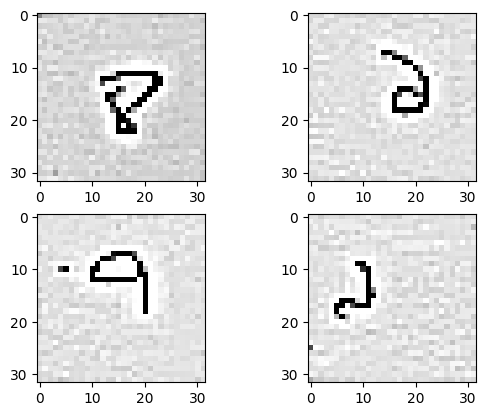

In [ ]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Histogram of digit

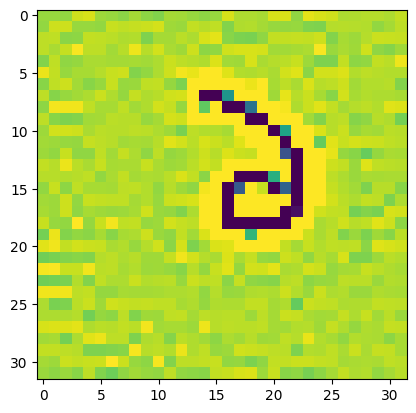

In [ ]:
plt.imshow(X_train_all[1])

In [ ]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 219/219
processed 2168/2168
processed 2106/2106


In [ ]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [ ]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17350, 32, 32)

We will now convert image to 1 color channel

In [ ]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

In [ ]:
X_train_all.shape

(72045, 32, 32, 1)

Normalize data

In [ ]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [ ]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]]
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]]
y_val=y_train_all[indices[-(len(indices)-ind):]]

## Step 2: Design the model

In [ ]:
def my_model(img_size=32,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()

    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

## Step 3: Train the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
# from your_custom_module import my_model  # make sure to import your model function

path_model = '/content/drive/MyDrive/modelsFinal/numtaDB.h5'

# Clear the session
tf.keras.backend.clear_session()

# Create the model
model = my_model()


# Assuming you're working on a multi-class classification with one-hot encoded labels
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
h = model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val,y_val),
    shuffle=True,
    callbacks=[ModelCheckpoint(filepath=path_model)]
)

Epoch 1/30
451/451 [==============================] - 22s 28ms/step - loss: 0.7755 - accuracy: 0.7334 - val_loss: 0.9959 - val_accuracy: 0.6667
Epoch 2/30
  1/451 [..............................] - ETA: 10s - loss: 0.1439 - accuracy: 0.9609

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


451/451 [==============================] - 11s 25ms/step - loss: 0.1506 - accuracy: 0.9568 - val_loss: 0.1298 - val_accuracy: 0.9616
Epoch 3/30
451/451 [==============================] - 11s 25ms/step - loss: 0.0971 - accuracy: 0.9735 - val_loss: 0.1215 - val_accuracy: 0.9650
Epoch 4/30
451/451 [==============================] - 12s 26ms/step - loss: 0.0780 - accuracy: 0.9786 - val_loss: 0.1976 - val_accuracy: 0.9525
Epoch 5/30
451/451 [==============================] - 11s 24ms/step - loss: 0.0619 - accuracy: 0.9824 - val_loss: 0.2164 - val_accuracy: 0.9303
Epoch 6/30
451/451 [==============================] - 11s 25ms/step - loss: 0.0524 - accuracy: 0.9852 - val_loss: 0.0902 - val_accuracy: 0.9760
Epoch 7/30
451/451 [==============================] - 11s 24ms/step - loss: 0.0479 - accuracy: 0.9858 - val_loss: 0.0927 - val_accuracy: 0.9751
Epoch 8/30
451/451 [==============================] - 12s 27ms/step - loss: 0.0394 - accuracy: 0.9888 - val_loss: 0.0864 - val_accuracy: 0.9770
Epo

 After 30 epochs we have a decent training and valiadation accuracy on dataset.

## Result Analysis

Let's observe the images by our model.

In [ ]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

543/543 [==============================] - 2s 3ms/step


In [ ]:
# n_sample=200
# np.random.seed(42)
# ind=np.random.randint(0,len(X_test_all), size=n_sample)

In [ ]:
# def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):

#     n_sample=len(X)
#     img_dim=X.shape[1]
#     j=np.ceil(n_sample/n_per_row)
#     fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
#     for i,img in enumerate(X):
#         plt.subplot(j,n_per_row,i+1)
#         plt.imshow(img)
#         if phase=='processed':
#             plt.title(np.argmax(y[i]))
#         if phase=='prediction':
#             top_n=3 # top 3 predictions with highest probabilities
#             ind_sorted=np.argsort(y_pred[i])[::-1]
#             h=img_dim+4
#             for k in range(top_n):
#                 string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
#                 plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
#                 h+=4
#             if y is not None:
#                 plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])),
#                          horizontalalignment='center',verticalalignment='center')
#         plt.axis('off')
#     plt.show()

In [ ]:
# def imshow_group(X, y, y_pred=None, n_per_row=10, phase='processed'):
#     n_sample = len(X)
#     img_dim = X.shape[1]
#     j = int(np.ceil(n_sample / n_per_row))  # Ensure j is an integer

#     fig = plt.figure(figsize=(FIG_WIDTH, HEIGHT_PER_ROW * j))


# imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

<Figure size 2000x6000 with 0 Axes>

In [ ]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [ ]:
keys=[get_key(path) for path in paths_test_all ]

In [ ]:
create_validation(predictions=labels,keys=keys,path='/content/drive/MyDrive/modelsFinal/validation.csv')

In [ ]:
prediction = pd.read_csv('/content/drive/MyDrive/modelsFinal/validation.csv')
prediction.head(100)

,key,label
0,a00983.png,6
1,a02648.png,4
2,a02935.png,6
3,a01067.png,6
4,a02741.png,8
...,...,...
95,a00920.png,8
96,a02630.png,0
97,a01623.png,2
98,a01331.png,7


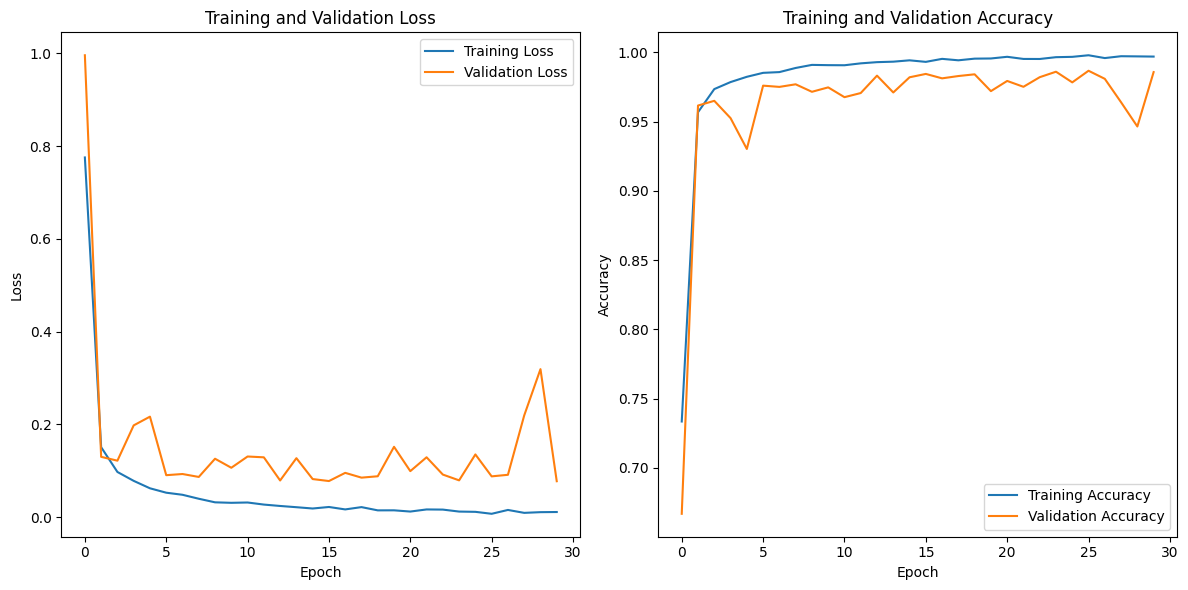

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/modelsFinal/numtaDB.keras')